Nice way to visualize toy networks:
https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.62505&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

In [1]:
### Classification
import torch
from torch import nn

import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from helper_functions import plot_decision_boundary, plot_predictions

In [2]:
n_samples = 1000

X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

X.shape, y.shape

((1000, 2), (1000,))

In [3]:
X.dtype

dtype('float64')

In [4]:
y.dtype

dtype('int64')

In [5]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

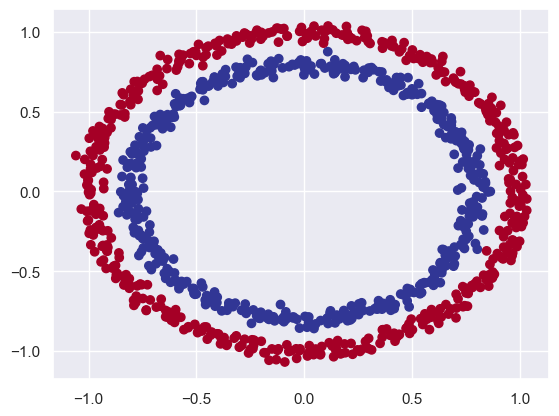

In [6]:
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "y": y})
# circles

plt.scatter(circles["X1"], circles["X2"], c=circles["y"], cmap=plt.cm.RdYlBu)

In [7]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X.dtype

torch.float32

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
len(X_train), len(X_test)

(800, 200)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer2(self.layer1(x))
    
model_0 = CircleModelV0().to(device)
next(model_0.parameters()).device

device(type='cuda', index=0)

In [12]:
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)

In [13]:
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.1487, -0.0686],
                      [-0.1780,  0.6327],
                      [ 0.6255,  0.6929],
                      [-0.0662, -0.2069],
                      [ 0.4649,  0.1811]], device='cuda:0')),
             ('layer1.bias',
              tensor([ 0.6975,  0.4430, -0.1623, -0.3209, -0.2922], device='cuda:0')),
             ('layer2.weight',
              tensor([[ 0.2653,  0.1441,  0.2301,  0.2127, -0.3745]], device='cuda:0')),
             ('layer2.bias', tensor([-0.4363], device='cuda:0'))])

In [14]:
model_0.eval()
with torch.inference_mode():
    untrained_preds = model_0(X.to(device))
    
untrained_preds[:10]

tensor([[-0.2382],
        [-0.0824],
        [-0.0735],
        [-0.0570],
        [-0.3400],
        [-0.0496],
        [-0.0852],
        [-0.2501],
        [-0.2607],
        [-0.0471]], device='cuda:0')

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [16]:
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    return torch.eq(y_true, y_pred).sum().item() / len(y_pred)

In [17]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))
    
y_logits[:5]

tensor([[-0.0602],
        [-0.0695],
        [-0.1446],
        [-0.0359],
        [-0.3172]], device='cuda:0')

In [18]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [19]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.4849],
        [0.4826],
        [0.4639],
        [0.4910],
        [0.4213]], device='cuda:0')

In [20]:
torch.round(y_pred_probs)[:5]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [21]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))
y_pred_labels[:5]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<SliceBackward0>)

In [22]:
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

### Training loop

In [23]:
y_logits[:5].dtype

torch.float32

In [24]:
y_train[:5].dtype

torch.float32

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 100

for epoch in range(epochs):
    model_0.train()
    
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if (epoch + 1) % 10 == 0:
        model_0.eval()
        with torch.inference_mode():
            test_logits = model_0(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {100*acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {100*test_acc:.2f}%")
       

Epoch: 9 | Loss: 0.69586, Accuracy: 46.62% | Test Loss: 0.69707, Test Accuracy: 42.50%
Epoch: 19 | Loss: 0.69478, Accuracy: 49.38% | Test Loss: 0.69619, Test Accuracy: 45.00%
Epoch: 29 | Loss: 0.69433, Accuracy: 48.88% | Test Loss: 0.69586, Test Accuracy: 49.50%
Epoch: 39 | Loss: 0.69409, Accuracy: 48.88% | Test Loss: 0.69570, Test Accuracy: 51.50%
Epoch: 49 | Loss: 0.69393, Accuracy: 49.38% | Test Loss: 0.69560, Test Accuracy: 52.00%
Epoch: 59 | Loss: 0.69381, Accuracy: 48.75% | Test Loss: 0.69552, Test Accuracy: 52.00%
Epoch: 69 | Loss: 0.69370, Accuracy: 49.12% | Test Loss: 0.69545, Test Accuracy: 51.00%
Epoch: 79 | Loss: 0.69362, Accuracy: 49.62% | Test Loss: 0.69539, Test Accuracy: 51.50%
Epoch: 89 | Loss: 0.69354, Accuracy: 49.75% | Test Loss: 0.69534, Test Accuracy: 51.00%
Epoch: 99 | Loss: 0.69347, Accuracy: 50.38% | Test Loss: 0.69529, Test Accuracy: 50.50%


# Plot decision boundary

In [26]:
import requests
from pathlib import Path

# Download helper functons from pytorch repo 
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists. Skipping download.")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", mode="wb") as f:
        f.write(request.content)


helper_functions.py already exists. Skipping download.


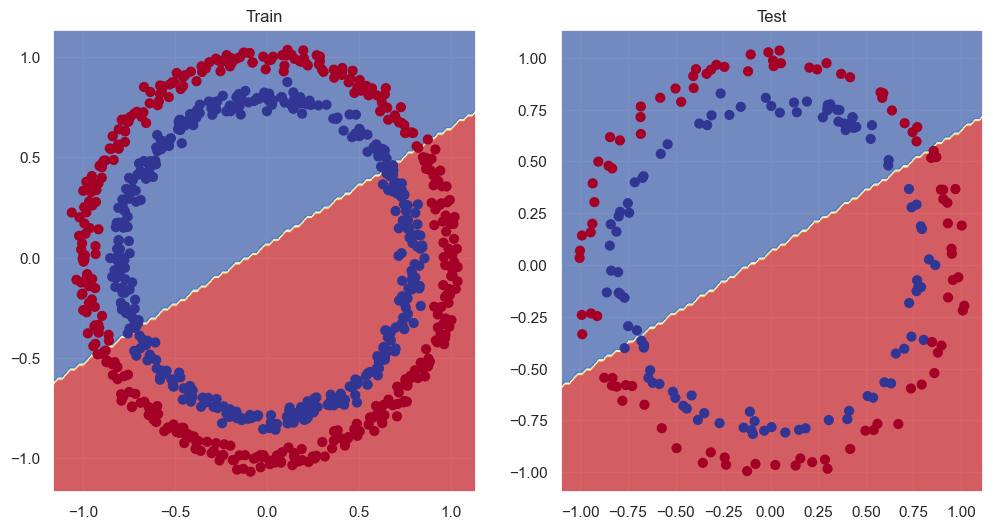

In [27]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Improving the model

In [28]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer3(self.layer2(self.layer1(x)))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [29]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [30]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [31]:
X_train.device

device(type='cuda', index=0)

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    model_1.train()
    
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if (epoch + 1) % 10 == 0:
        model_1.eval()
        with torch.inference_mode():
            test_logits = model_1(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {100*acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {100*test_acc:.2f}%")
       

Epoch: 9 | Loss: 0.69504, Accuracy: 50.00% | Test Loss: 0.69435, Test Accuracy: 50.00%
Epoch: 19 | Loss: 0.69410, Accuracy: 56.50% | Test Loss: 0.69369, Test Accuracy: 55.00%
Epoch: 29 | Loss: 0.69373, Accuracy: 51.75% | Test Loss: 0.69347, Test Accuracy: 56.50%
Epoch: 39 | Loss: 0.69356, Accuracy: 49.75% | Test Loss: 0.69338, Test Accuracy: 55.50%
Epoch: 49 | Loss: 0.69347, Accuracy: 50.00% | Test Loss: 0.69335, Test Accuracy: 54.50%
Epoch: 59 | Loss: 0.69341, Accuracy: 49.62% | Test Loss: 0.69333, Test Accuracy: 55.00%
Epoch: 69 | Loss: 0.69337, Accuracy: 49.38% | Test Loss: 0.69333, Test Accuracy: 54.50%
Epoch: 79 | Loss: 0.69333, Accuracy: 49.50% | Test Loss: 0.69333, Test Accuracy: 53.50%
Epoch: 89 | Loss: 0.69330, Accuracy: 49.62% | Test Loss: 0.69333, Test Accuracy: 53.00%
Epoch: 99 | Loss: 0.69327, Accuracy: 49.62% | Test Loss: 0.69334, Test Accuracy: 54.00%
Epoch: 109 | Loss: 0.69325, Accuracy: 49.62% | Test Loss: 0.69335, Test Accuracy: 53.50%
Epoch: 119 | Loss: 0.69323, Accu

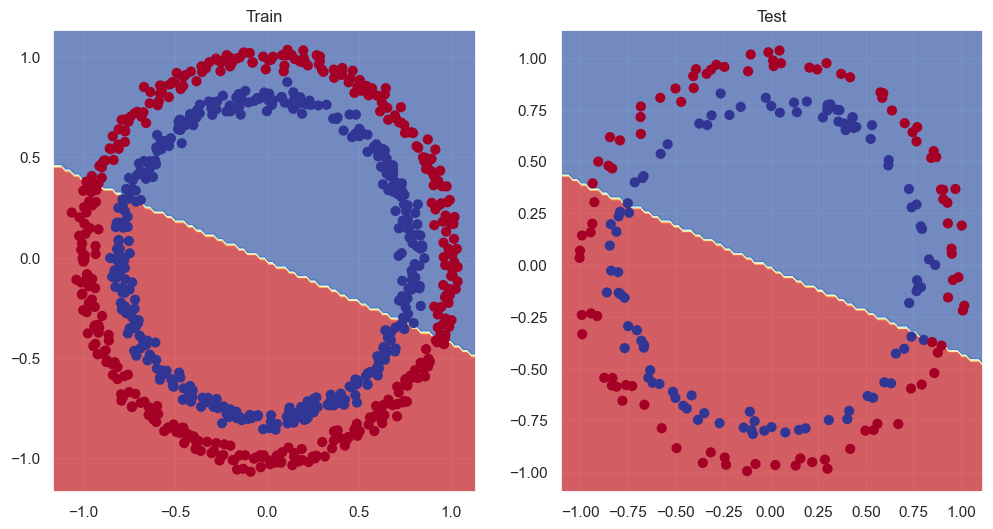

In [33]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [34]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [35]:
### Sanity check on linear model

# linear regression formula to make a linear dataset

weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias


# splitting data in training and testing datasets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train_regression, y_train_regression = X[:train_size], y[:train_size]
X_test_regression, y_test_regression = X[train_size:], y[train_size:]

print(X_train.shape, X_test.shape)

X_train_regression = X_train_regression.to(device)
y_train_regression = y_train_regression.to(device)
X_test_regression = X_test_regression.to(device)
y_test_regression = y_test_regression.to(device)

torch.Size([800, 2]) torch.Size([200, 2])


In [36]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)


loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.001)

torch.manual_seed(42)
epochs = 1500

epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
    model_2.train()
    train_pred = model_2(X_train_regression)
    train_loss = loss_fn(train_pred, y_train_regression)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        model_2.eval()
        with torch.inference_mode():
            test_pred = model_2(X_test_regression)
            test_loss = loss_fn(test_pred, y_test_regression)
        epoch_count.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        print(f'Epoch {epoch}: Loss {train_loss.item():.4f}, Test Loss {test_loss.item():.4f}')

Epoch 0: Loss 0.7599, Test Loss 0.9497
Epoch 100: Loss 0.4027, Test Loss 0.5403
Epoch 200: Loss 0.0588, Test Loss 0.1348
Epoch 300: Loss 0.0146, Test Loss 0.0334
Epoch 400: Loss 0.0031, Test Loss 0.0001
Epoch 500: Loss 0.0031, Test Loss 0.0001
Epoch 600: Loss 0.0031, Test Loss 0.0002
Epoch 700: Loss 0.0030, Test Loss 0.0001
Epoch 800: Loss 0.0030, Test Loss 0.0002
Epoch 900: Loss 0.0029, Test Loss 0.0001
Epoch 1000: Loss 0.0029, Test Loss 0.0001
Epoch 1100: Loss 0.0029, Test Loss 0.0002
Epoch 1200: Loss 0.0028, Test Loss 0.0001
Epoch 1300: Loss 0.0028, Test Loss 0.0002
Epoch 1400: Loss 0.0028, Test Loss 0.0002


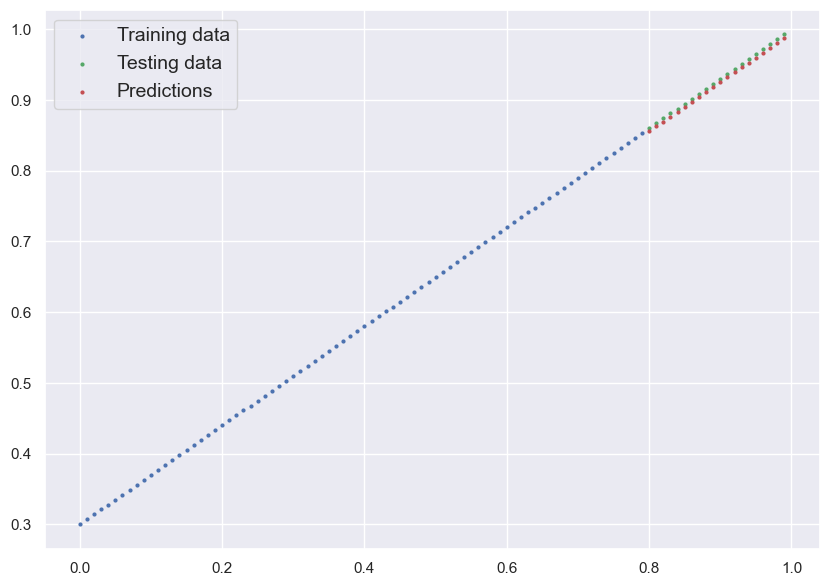

In [37]:
model_2.eval()
with torch.inference_mode():
    test_pred = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression, predictions=test_pred)

# Introducing nonlinearity

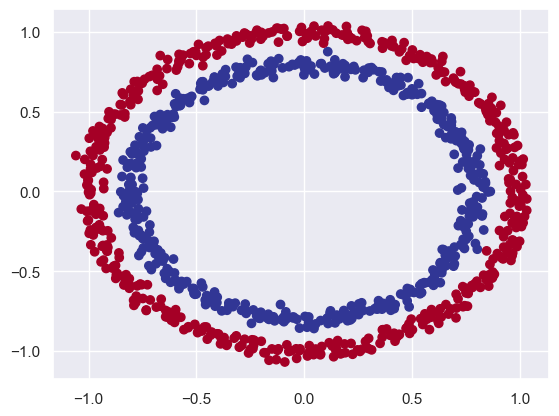

In [38]:
n_samples = 1000

X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "y": y})

plt.scatter(circles["X1"], circles["X2"], c=circles["y"], cmap=plt.cm.RdYlBu)
plt.show()

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [39]:

class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
    
model_3 = CircleModelV3().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
for epoch in range(epochs):
    model_3.train()
    
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        model_3.eval()
        with torch.inference_mode():
            test_logits = model_3(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {100*acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {100*test_acc:.2f}%")

Epoch: 99 | Loss: 0.69117, Accuracy: 53.00% | Test Loss: 0.69104, Test Accuracy: 52.50%
Epoch: 199 | Loss: 0.68979, Accuracy: 53.37% | Test Loss: 0.68941, Test Accuracy: 55.00%
Epoch: 299 | Loss: 0.68797, Accuracy: 53.00% | Test Loss: 0.68726, Test Accuracy: 56.00%
Epoch: 399 | Loss: 0.68520, Accuracy: 52.75% | Test Loss: 0.68415, Test Accuracy: 56.50%
Epoch: 499 | Loss: 0.68107, Accuracy: 52.75% | Test Loss: 0.67947, Test Accuracy: 56.50%
Epoch: 599 | Loss: 0.67522, Accuracy: 54.37% | Test Loss: 0.67293, Test Accuracy: 56.00%
Epoch: 699 | Loss: 0.66670, Accuracy: 58.38% | Test Loss: 0.66333, Test Accuracy: 59.00%
Epoch: 799 | Loss: 0.65179, Accuracy: 64.00% | Test Loss: 0.64776, Test Accuracy: 67.50%
Epoch: 899 | Loss: 0.62401, Accuracy: 74.00% | Test Loss: 0.62180, Test Accuracy: 78.50%
Epoch: 999 | Loss: 0.56890, Accuracy: 87.62% | Test Loss: 0.57440, Test Accuracy: 86.50%


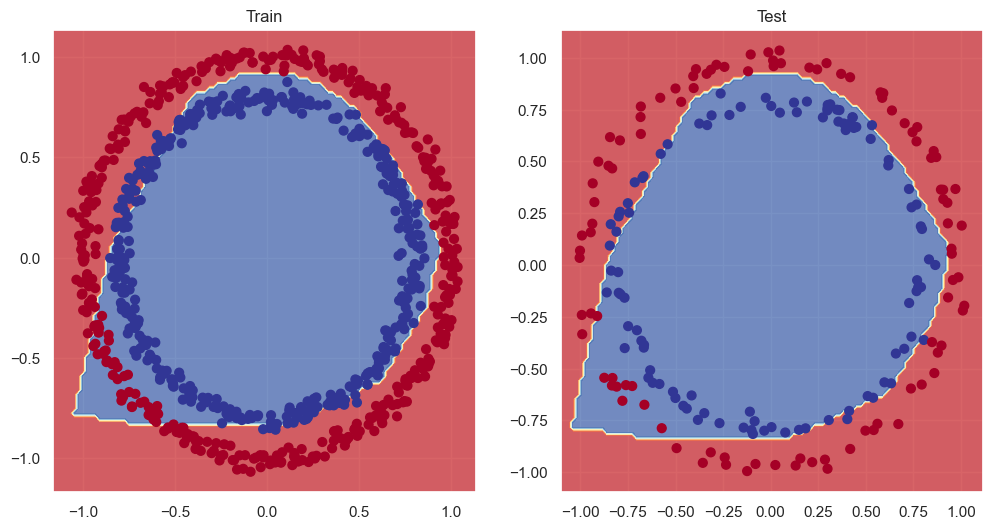

In [40]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)